In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%capture

# Import everything from the data_utils library
from data_utils import *

# Load the talk data
talk_data = get_only_talks(load_data())

In [3]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
prop_cycle = pl.cycler(color=['#377eb8','#e41a1c','#4daf4a','#984ea3',
                              '#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

# General statistics on general conference
This document is an overview of general statistics from general conference. Some of this is based on data published at www.lds-general-conference.org. Their data goes back to the 1850s, while other parts of this data analysis are based on data published online by BYU, which goes from 1942 to the present.

## The standard works
We begin our analysis with an overview of the LDS standard works, consisting (in English) of the King James Version of the Bible, the Book of Mormon, Doctrine and Covenants, and The Pearl of Great Price. The pie chart below illustrates their relative sizes. Roughly speaking, the Bible represents roughly 2/3 of the nearly 1.2 million words in the standard works, and the Book of Mormon nearly 1/4.

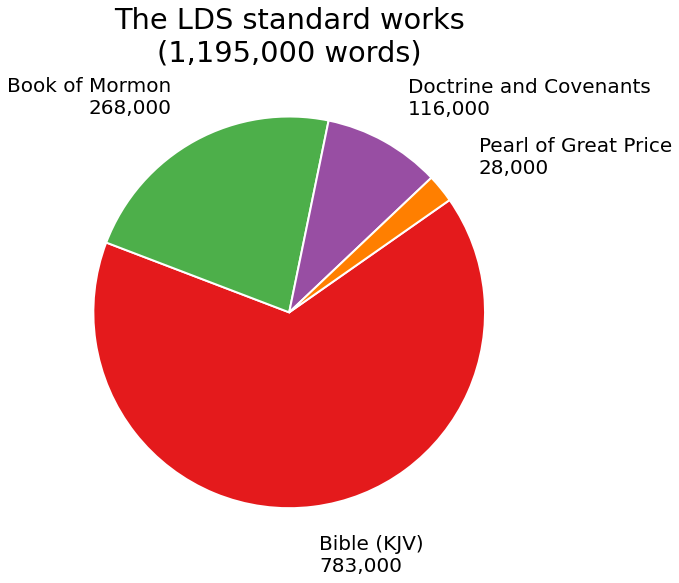

In [4]:
decade_word_counts = pd.read_table('data/general_counts.txt').set_index('decade')
scripture_word_counts = {'Bible (KJV)': 783137,
                         'Book of Mormon': 267846,
                         'Doctrine and Covenants': 115658,
                         'Pearl of Great Price': 28366}
scripture_data = pd.Series(scripture_word_counts).to_frame('words')
scripture_data_r = (scripture_data/1000).round().astype(int)*1000
word_counts = scripture_data_r.sum()[0]

fig, ax = pl.subplots()
ax.set_prop_cycle(prop_cycle[1:])
labels = scripture_data_r.index + '\n' + \
         scripture_data_r['words'].map(lambda x: '{:,d}'.format(x))
ax.pie(scripture_data_r['words'],
       labels=labels,
       labeldistance=1.25,
       wedgeprops={'linewidth':2, 'edgecolor':'white'},
       startangle=35,
       counterclock=False)
pl.title('The LDS standard works\n({0:,d} words)'.format(word_counts))
pl.subplots_adjust(bottom=0.05, top=0.9, right=0.85)

## Words spoken in general conference by decade
The plot below shows the total count of words spoken in general conference in each decade since the 1850s. The standard works are included for reference. There is some variation, but the word count of every single completed decade exceeds the size of the standard works, with an average of 1.46 million words per decade.

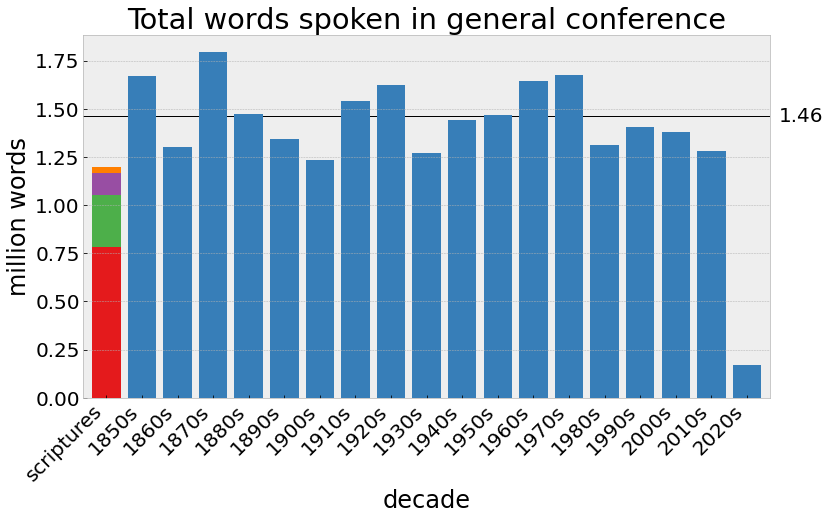

In [5]:
mean_words = decade_word_counts[:-1]['words'].mean()/1e6
dwc_plot_data = decade_word_counts.drop(columns='talks').append(scripture_data.transpose())
dwc_plot_data = dwc_plot_data[-1:].append(dwc_plot_data[:-1]).fillna(0)/1e6
dwc_plot_data.plot.bar(stacked=True, legend=False, width=0.8, rot=45, #lc='white',
                       ylabel='million words',
                       xlabel='decade',
                       title='Total words spoken in general conference')
pl.axhline(y=mean_words,
           color='black', linewidth=1, zorder=0)
pl.text(len(dwc_plot_data)-0.1, mean_words, '{0:.2f}'.format(mean_words),
        horizontalalignment='left', verticalalignment='center')
labels = ['scriptures'] + list(decade_word_counts.index)
pl.xticks(range(len(labels)), labels, rotation=45, ha='right')
pl.subplots_adjust(bottom=0.25, right=0.92)
pl.grid(axis='x')

## Talk length
The plot below shows the average plot length per decade. While total number of words per conference has remained relatively constant, the average talk length during the 19th century was significantly longer, sometimes in the range of 4000-5000 words. Since about 1900, the average has been just under 2000 words, declining gradually since the 1970s to an average to date in the 2020s of just 1652 words.

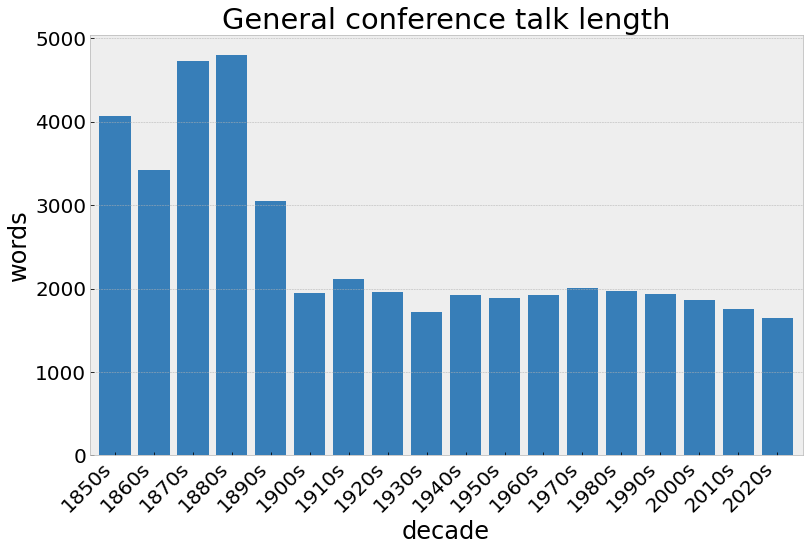

In [6]:
talk_length = decade_word_counts['words']/decade_word_counts['talks']
talk_length.plot.bar(width=0.8, rot=45,
                     ylabel='words',
                     xlabel='decade',
                     title='General conference talk length')
pl.xticks(ha='right')
pl.grid(axis='x')

In [7]:
%%capture

df_all = load_data(source='file')
talks_only = get_only_talks(df_all)

apostle_data = load_apostle_data()
apostle_data['short name'] = apostle_data['name'].map(shorten_name)
apostle_sn_dict = apostle_data[['name', 'short name']].set_index('name').to_dict()['short name']
president_list = apostle_data[~apostle_data['sdate_p'].isna()]['name'].to_list()
recent_presidents = talks_only['president'].unique()
recent_presidents_ln = [x.split(' ')[-1] for x in recent_presidents]

## Who has given the most talks?
Using the full-text talk data going back to 1942, the following analysis shows which speakers have given the most talks. The plot below shows the top 20 speakers in number of talks given since 1942. A few of them, such as David O. McKay and J. Reuben Clark, were already apostles in 1942, so their actual total may be somewhat higher. However, many of the others' totals reflect their their entire general conference speaking career. It appears that the factors leading to giving a lot of talks include becoming president of the church, serving in the First Presidency prior to becoming president of the church, and being called an apostle relatively young.

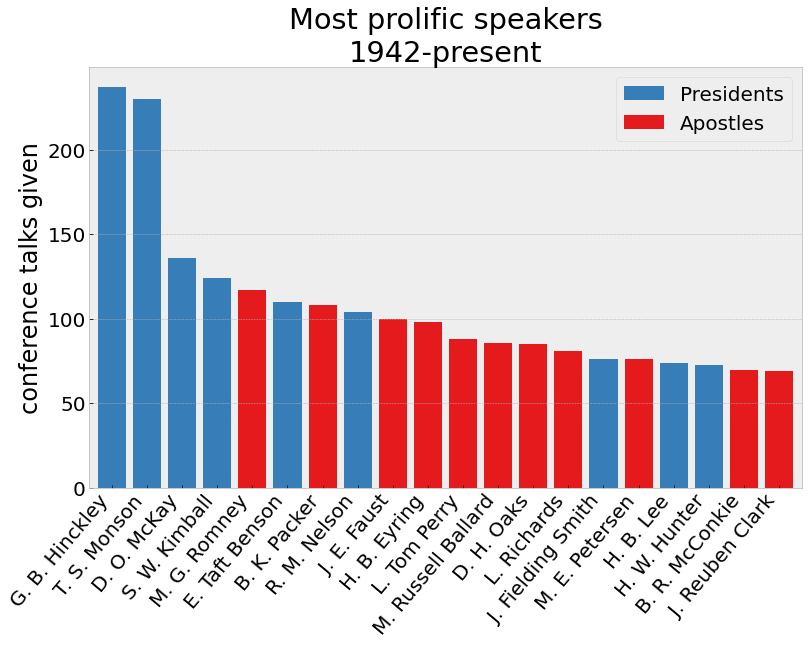

In [8]:
talk_count = talks_only.groupby('author').size().sort_values(
    ascending=False)[:20].to_frame('talks')
talk_count['pres'] = ~talk_count.index.isin(president_list)
talk_count = talk_count.pivot(columns='pres', values='talks').fillna(0)
talk_count.columns = ['Presidents', 'Apostles']
talk_count['sum'] = talk_count.sum(1)
talk_count = talk_count.sort_values('sum', ascending=False).drop(columns=['sum'])
talk_count.index = [apostle_sn_dict[x] for x in talk_count.index]

talk_count.plot.bar(width=0.8, stacked=True, rot=50,
                    ylabel='conference talks given',
                    title='Most prolific speakers\n1942-present')
pl.xticks(ha='right', va='top')
pl.grid(axis='x')

While all of the most prolific general conference speakers were apostles or presidents of the church, it is also interesting to consider which of those who were not apostles gave the most talks, which is shown in the chart below. At the top of the list is Eldred G. Smith, who held the calling of Patriarch to the Church from 1947 to 1979. In that role he spoke at least once each year in general conference.

It may be surprising to some to see Bruce R. McConkie at the top of the list. While he is often remembered as the apostle who wrote *Mormon Doctrine*, he in fact published that book while he was a Seventy, and he held that office for 26 years prior to being called an apostle. He was an apostle for only the last 13 years of his life, so a majority of his general conference talks were given while he was a Seventy.

The fact that so many of the Seventies on this list are from many decades ago reflects changes in leadership structure. The First Council of the Seventy, as it was called prior to 1975, was a much smaller group, and its members were given more frequent opportunities to speak in general conference.

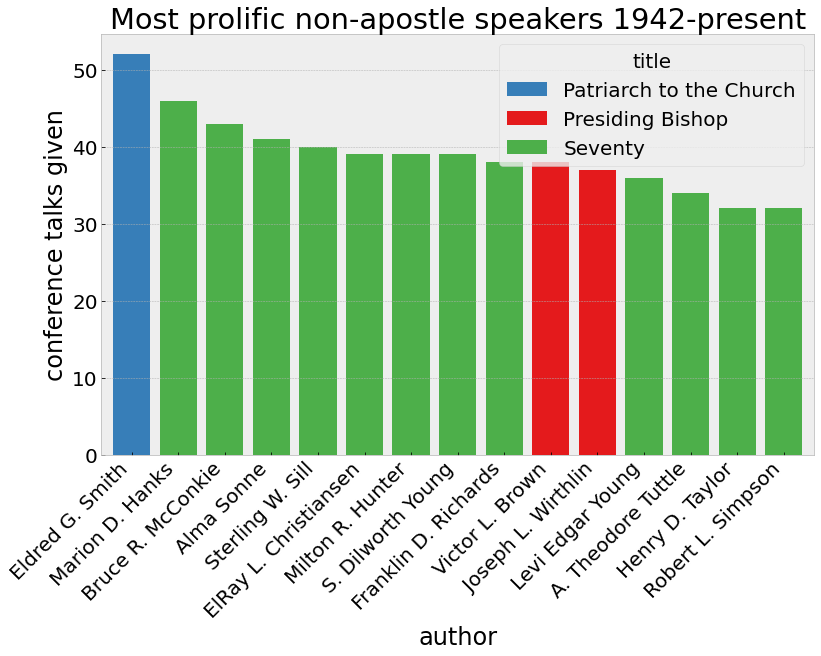

In [9]:
talk_count_na = talks_only[talks_only['rank']==100].groupby('author').size()
talk_count_na = talk_count_na.to_frame('talks').sort_values('talks', ascending=False)[:15]
talk_count_na['title'] = 'Seventy'
talk_count_na.loc['Eldred G. Smith', 'title'] = 'Patriarch to the Church'
talk_count_na.loc[['Victor L. Brown', 'Joseph L. Wirthlin'], 'title'] = 'Presiding Bishop'
talk_count_na = talk_count_na.pivot(columns='title', values='talks').fillna(0)
talk_count_na['sum'] = talk_count_na.sum(1)
talk_count_na = talk_count_na.sort_values('sum', ascending=False).drop(columns=['sum'])

talk_count_na.plot.bar(stacked=True, width=0.8, rot=45,
                       ylabel='conference talks given',
                       title='Most prolific non-apostle speakers 1942-present')
pl.xticks(ha='right', va='top')
pl.grid(axis='x')
#pl.gca().set_ylim(top=70)
#pl.subplots_adjust(bottom=0.38, left=0.15)


The chart below shows the number of talks given by current apostles and First Presidency members prior to their being called as apostles. David A. Bednar is the only one to have never given in general conference talk prior to his call. While neither Russell M. Nelson nor Dallin H. Oaks had been general authorities prior to being called apostles in 1984, both had spoken in general conference previously. Nelson spoke in 1969 while serving as a stake president, and Oaks during the 1970s while president of BYU.

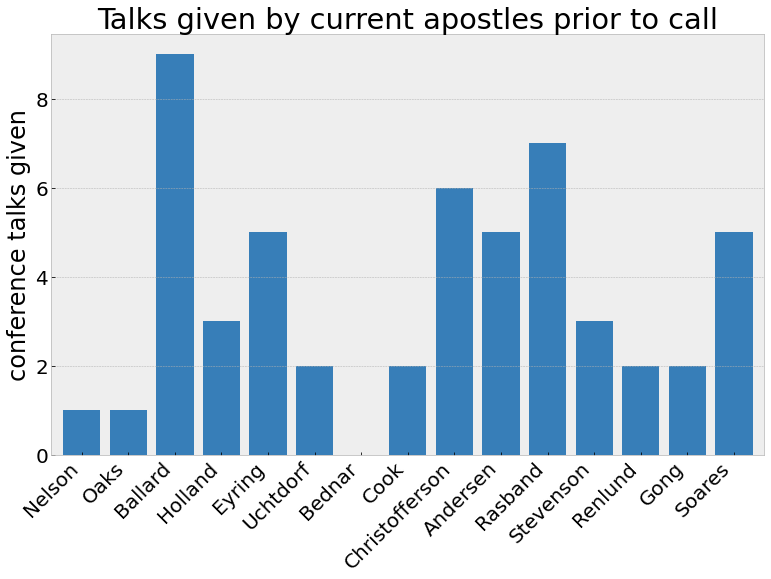

In [10]:
current_q15 = talks_only[(talks_only['date']==talks_only.iloc[-1]['date']) &
                         (talks_only['rank']<20)]['author'].drop_duplicates().to_list()
current_q15_talk_count = talks_only[(talks_only['author'].isin(current_q15)) &
                                    (talks_only['rank']>20)].groupby('author').size()
asd = apostle_data[apostle_data['dod'].isna()][['name', 'sdate']].set_index('name')
current_q15_talk_count = current_q15_talk_count.to_frame('talks').join(
    asd, how='outer').fillna(0).sort_values('sdate').drop(columns='sdate')
current_q15_talk_count.index = current_q15_talk_count.index.map(lambda x: x.split(' ')[-1])

current_q15_talk_count.plot.bar(
    width=0.8,
    rot=45,
    legend=False,
    ylabel='conference talks given',
    title='Talks given by current apostles prior to call')
pl.xticks(ha='right', va='top')
pl.grid(axis='x')

## Scripture citations
The plot below shows the frequency of scriptural citations over time. After staying at a relatively constant 5 citations per 1000 words, the citation rate started a steady upward trajectory in the 1980s, and is now over triple what it was decades ago. It is important to note that scriptural citations are not necessarily scriptural quotations. The published versions of general conference talks today are heavily footnoted and may contain multiple scriptural references in a single footnote. The trend toward more scripture citations in talks can likely be explained by the advent of personal computers, word processors and electronically indexed scriptures.

<AxesSubplot:title={'center':'Scripture citation rate'}, xlabel='year', ylabel='references per thousand words'>

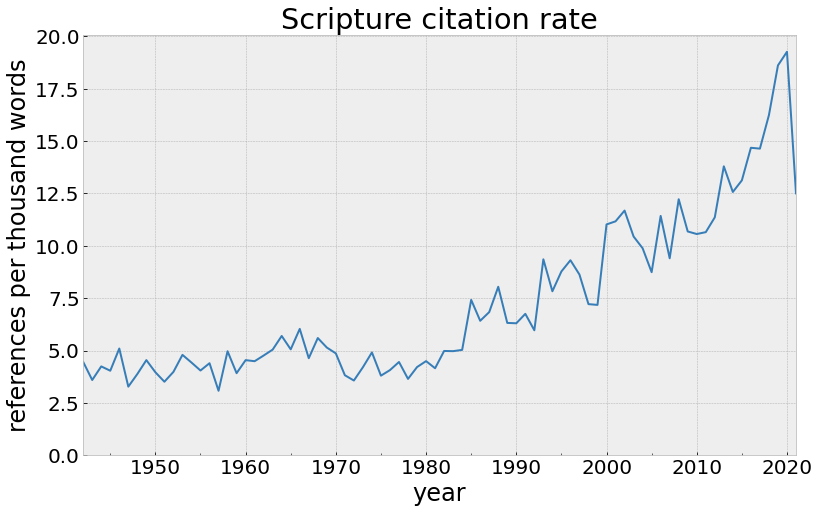

In [11]:
# Process references
group = 'year'
ref_df = get_scripture_refs(talks_only)
ref_counts_raw = get_ref_counts(ref_df, group)
ref_rate = ref_counts_raw.divide(talks_only.groupby(group).sum()['word_count'], 0)*1e3
rpm_str = 'references per thousand words'
ref_rate.columns = ref_rate.columns.get_level_values(1)
ref_rate.columns.name = 'Standard Work'
ref_rate_total = ref_rate.sum(1)
ref_rate_frac = ref_rate.divide(ref_rate_total, 0)*100

ref_freq = ref_df.groupby('ref').count()[group].to_frame('uses')
num_refs = 20
top_refs = ref_freq.sort_values('uses').iloc[-num_refs:][::-1]

top_refs_sw = ref_df[['ref', 'sw']].drop_duplicates().merge(top_refs, on='ref')
top_refs_swcols = top_refs_sw.pivot(index='ref', columns='sw', values='uses').fillna(0).astype(int)
top_refs_swcols['all'] = top_refs_swcols.sum(1)
top_refs_swcols = top_refs_swcols.sort_values('all', ascending=False).drop(columns='all')
top_refs_swcols.columns = pandas.Index(
    ['Book of Mormon', 'Doctrine & Covenants',
     'New Testament', 'Pearl of Great Price'], name='standard work')


ref_rate_total.plot(
    ylabel=rpm_str,
    ylim=[0, None],
    title='Scripture citation rate')

In [12]:
#ref_df['5 year period'] = ref_df['date'].dt.year.map(lambda x: datetime.date(int(x/5)*5+2, 6, 1))
#ref_df[ref_df['ref']=='2 Ne. 31:20'].groupby('5 year period').size().plot()

The plot below shows the same scripture citation data broken down by standard work. From this chart, it becomes apparent that nearly all of the increase in citations come from references in the New Testament, Book of Mormon, and Doctrine & Covenants. In the early decades of the data, the New Testament was the most cited standard work, while the Book of Mormon has now become the most cited, as is apparent from the next chart showing the same data as a fraction of the whole.

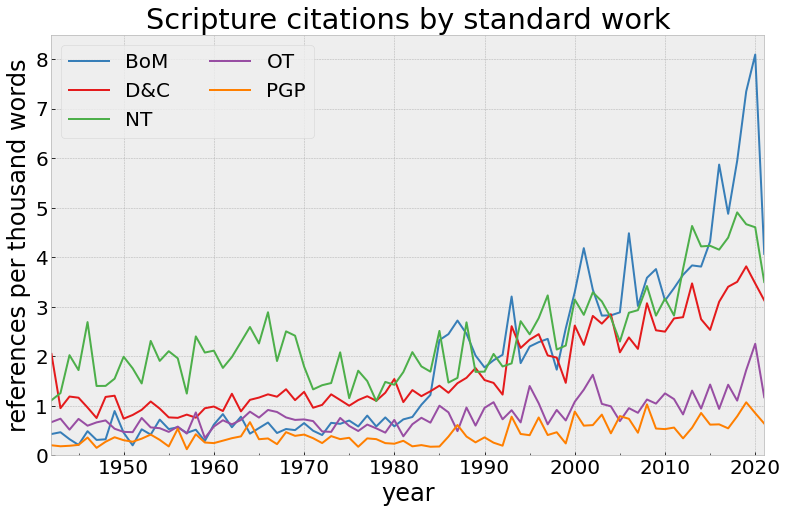

In [13]:
ref_rate.plot(
    ylabel=rpm_str,
    ylim=[0, None],
    title='Scripture citations by standard work')
_ = pl.legend(ncol=2)

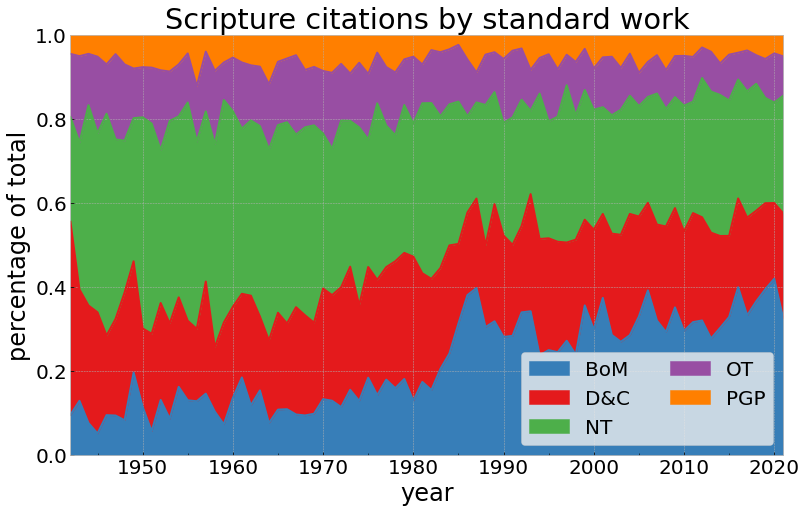

In [14]:
ref_rate.divide(ref_rate.sum(1), 0).plot.area(
    ylabel='percentage of total',
    ylim=[0, 1],
    title='Scripture citations by standard work')
_ = pl.legend(ncol=2)

The shift in emphasis from the New Testament to the Book of Mormon can be very clearly traced to the 1980s, and is likely a response to Ezra Taft Benson's emphasis on the Book of Mormon. A very clear shift occurs in a 3-4 period, and that shift in emphases persists today over 3 decades later.

The chart below shows the 20 most cited scriptures since 1942. Moses 1:39 is the most popular by far, with nearly double the citations of the next one after it (JS--H 1:17). It is remarkable that the two most-cited individual verses are both from the Pearl of Great Price given that it has always been the least-cited standard work.

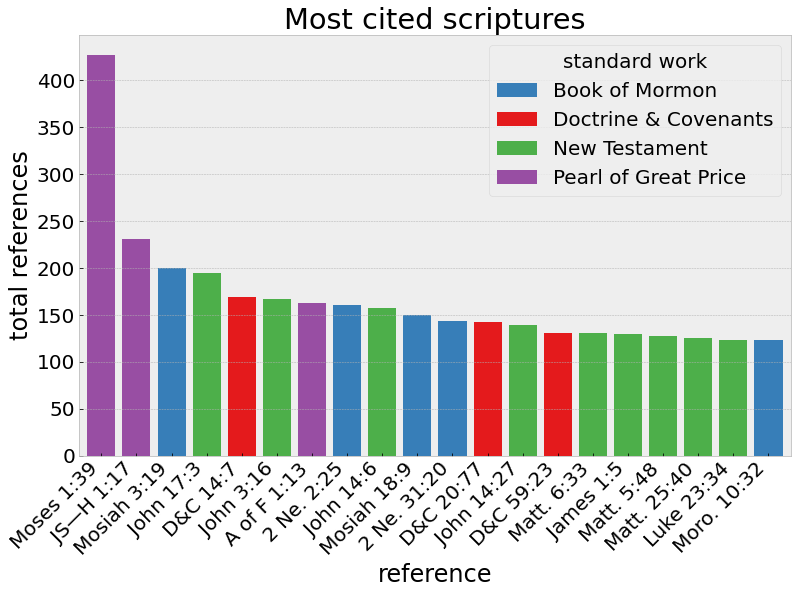

In [15]:
top_refs_swcols.plot.bar(
    stacked=True, width=0.8, rot=45,
    ylabel='total references',
    xlabel='reference',
    title='Most cited scriptures')
pl.xticks(ha='right')
pl.grid(axis='x')

In [16]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')